<a href="https://colab.research.google.com/github/JasonDepblu/potential-spork/blob/new_embeddings_model/new_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 导入相关模块及数据

In [1]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.6 MB/s eta 0:00:00


In [2]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.5 MB/s eta 0:00:00


In [3]:
pip install tqdm

In [4]:
# 导入模块
import time
import pandas as pd
import numpy as np
import random
import mpl_toolkits.axisartist as ast
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow import keras
import tensorflow as tf
from keras import layers, models, optimizers
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, auc
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import copy
import shap
import scipy
from collections import UserList
from tabulate import tabulate
from tensorflow.keras.callbacks import ModelCheckpoint

In [5]:
import re

In [6]:
import torch

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
from transformers import BertModel
from transformers import BertTokenizer

In [9]:
from transformers import BertTokenizer, TFBertModel

In [10]:
from transformers import AdamW
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [11]:
from tqdm import tqdm

In [12]:

# Load the dataset
file_path_car = '/content/car_dict_e8_emb.csv'
car_data = pd.read_csv(file_path_car)

file_path_user = '/content/dsc_up_e8.csv'
user_data = pd.read_csv(file_path_user)

# Display the first few rows of the dataframe
car_data.head()
user_data.head()

Columns (300,302,303,307,309,312,313,314,315,316,317) have mixed types. Specify dtype option on import or set low_memory=False.


,fkoubeiid,comments,purposes,province,city,budget,drivenkiloms,driving _months,km/d,fseriesname,fseriesid,fspecid,no_in_car_dict,type
0,5172505,【最满意的一点】\r\n我的用车需求匹配下来最合适的就是MPV，本来MPV市场可选的车型就不...,"上下班,购物,接送小孩,自驾游,商务差旅",四川,成都,29,1300,2.0,21.68,传祺M8,4174,58244,37,传祺M8 2024款 双擎系列 2.0TM 基本型
1,5168778,【最满意的一点】\r\n油耗很低，虽然买了一辆这么大的车，但载着一大家子出行，一般情况下油耗...,"上下班,自驾游,跑长途",上海,上海,32,6632,7.9,27.81,传祺M8,4174,60142,38,传祺M8 2023款 宗师系列 双擎 旗舰
2,5168549,【最满意的一点】\r\n现在不加价，在同价位的MPV中，我觉得赛那还是挺适合的，毕竟它的空间...,"上下班,自驾游,跑长途",北京,北京,36,3526,3.9,29.77,赛那SIENNA,6272,61955,121,赛那SIENNA 2023款 2.5L混动 尊贵版
3,5168444,【最满意的一点】\r\n空间是这个车子最大的优势，同时内部的配置也非常的齐全，再加上价格也比...,NaN,福建,厦门,10,0,0.9,0.00,五菱佳辰,6650,55788,2,五菱佳辰 2022款 1.5T CVT尊享旗舰型
4,5168430,【最满意的一点】\r\n公司业务需求里面需要外地出差考虑换一台商务车，公司换车首选就是别克陆...,"上下班,跑长途,商务差旅",河南,商丘,30,2400,0.9,91.26,别克GL8,166,58900,101,别克GL8 2023款 ES陆尊 653T 舒适型


# `预处理data`

In [13]:
# Remove columns with only one unique value
columns_to_drop = car_data.columns[car_data.nunique() <= 1]
car_data_reduced = car_data.drop(columns=columns_to_drop)

In [14]:
car_data_reduced.head(10)

,fspecid,price,quick_charge_time(80%),slow_charge_time,power_car,最大净功率,torque_car,gears,max_speed,time_for_100km_h,...,第二排座椅电动调节,第二排座椅功能,后排液晶屏幕尺寸,第三排座椅功能,第三排座椅调节,可见即可说,语音免唤醒词,语音分区域唤醒识别,手机app远程功能,title
0,56818,8.18,0.0,0.0,108,104,250,6,170,10.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,五菱佳辰
1,56817,9.18,0.0,0.0,108,104,250,0,170,10.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,五菱佳辰
2,55788,9.98,0.0,0.0,108,104,250,0,170,10.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,五菱佳辰
3,41053,11.98,0.0,0.0,124,117,265,7,190,11.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,传祺M6
4,47564,10.98,0.0,0.0,124,117,265,6,195,10.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,传祺M6
5,60951,15.98,0.0,0.0,130,125,270,7,190,9.40,...,-,-,NaN,NaN,NaN,-,●,-,●车门控制\r\n●车辆启动\r\n●空调控制\r\n●座椅加热\r\n●车况查询/诊断\r...,传祺M6
6,60948,12.98,0.0,0.0,130,125,270,7,190,9.40,...,-,-,NaN,NaN,NaN,-,-,-,-,传祺M6
7,60949,13.98,0.0,0.0,130,125,270,7,190,9.40,...,-,-,NaN,NaN,NaN,-,-,-,-,传祺M6
8,60950,14.98,0.0,0.0,130,125,270,7,190,9.40,...,-,-,NaN,NaN,NaN,-,-,-,-,传祺M6
9,47571,14.98,0.0,0.0,124,117,265,7,190,11.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,传祺M6


In [15]:
# Define the new function to handle multiple ● symbols
def replace_with_detailed_feature_description(cell, feature_name):
    if pd.isna(cell):
        return cell  # Keep NaN as is
    elif isinstance(cell, str):
        # Replace specific symbols with words
        cell = cell.replace('●', '有').replace('○', '选配').replace('-', '不具有').replace('NULL', '未知')
        # Find all occurrences of "有" which indicates a feature is present
        features = cell.split()
        feature_descriptions = []
        for feature in features:
            if feature.startswith('有'):
                feature_description = feature[1:]  # Remove the '有' prefix
                feature_descriptions.append(feature_description)
        if feature_descriptions:
            return f"具备{feature_name}功能，" + "、".join(feature_descriptions)
        else:
            # If there are no '有', but the cell is not empty or NaN, it means
            # it's either '选配', '不具有' or '未知'
            return cell + feature_name + "功能"
    else:
        return cell  # Keep the original value if it doesn't match the above


In [16]:
# Apply the new function to each non-numeric cell
for column in car_data_reduced.columns:
    if car_data_reduced[column].dtype == 'object':  # Apply only to non-numeric columns
        feature_name = column.strip()  # Clean up the column name if necessary
        car_data_reduced[column] = car_data_reduced[column].apply(lambda cell:
                               replace_with_detailed_feature_description(cell, feature_name))


In [17]:
car_data_reduced.head(10)

,fspecid,price,quick_charge_time(80%),slow_charge_time,power_car,最大净功率,torque_car,gears,max_speed,time_for_100km_h,...,第二排座椅电动调节,第二排座椅功能,后排液晶屏幕尺寸,第三排座椅功能,第三排座椅调节,可见即可说,语音免唤醒词,语音分区域唤醒识别,手机app远程功能,title
0,56818,8.18,0.0,0.0,108,104,250,6,170,10.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,五菱佳辰title功能
1,56817,9.18,0.0,0.0,108,104,250,0,170,10.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,五菱佳辰title功能
2,55788,9.98,0.0,0.0,108,104,250,0,170,10.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,五菱佳辰title功能
3,41053,11.98,0.0,0.0,124,117,265,7,190,11.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,传祺M6title功能
4,47564,10.98,0.0,0.0,124,117,265,6,195,10.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,传祺M6title功能
5,60951,15.98,0.0,0.0,130,125,270,7,190,9.40,...,不具有第二排座椅电动调节功能,不具有第二排座椅功能功能,NaN,NaN,NaN,不具有可见即可说功能,具备语音免唤醒词功能，,不具有语音分区域唤醒识别功能,具备手机app远程功能功能，车门控制、车辆启动、空调控制、座椅加热、车况查询/诊断、车辆定位/寻车,传祺M6title功能
6,60948,12.98,0.0,0.0,130,125,270,7,190,9.40,...,不具有第二排座椅电动调节功能,不具有第二排座椅功能功能,NaN,NaN,NaN,不具有可见即可说功能,不具有语音免唤醒词功能,不具有语音分区域唤醒识别功能,不具有手机app远程功能功能,传祺M6title功能
7,60949,13.98,0.0,0.0,130,125,270,7,190,9.40,...,不具有第二排座椅电动调节功能,不具有第二排座椅功能功能,NaN,NaN,NaN,不具有可见即可说功能,不具有语音免唤醒词功能,不具有语音分区域唤醒识别功能,不具有手机app远程功能功能,传祺M6title功能
8,60950,14.98,0.0,0.0,130,125,270,7,190,9.40,...,不具有第二排座椅电动调节功能,不具有第二排座椅功能功能,NaN,NaN,NaN,不具有可见即可说功能,不具有语音免唤醒词功能,不具有语音分区域唤醒识别功能,不具有手机app远程功能功能,传祺M6title功能
9,47571,14.98,0.0,0.0,124,117,265,7,190,11.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,传祺M6title功能


In [18]:
# Define the path for the cleaned CSV file
cleaned_file_path = '/content/cleaned_car_data.csv'

# Save the cleaned dataframe to a CSV file
car_data_reduced.to_csv(cleaned_file_path, index=False)  # Set index to False to avoid saving the index


In [19]:
dsc_up = user_data.values
car_dict = car_data_reduced.values

print(dsc_up.shape)
print(car_dict.shape)

(5520, 14)
(142, 239)


In [20]:
# column of last feature from 0 and +1
col_last_feature_car = 238
# 80
col_last_num_feature_car = 38

col_last_feature_user = 9

col_last_num_feature_user = 5

# 提取特征列表
dsc_up_features = user_data.columns.tolist()
car_dict_features = car_data_reduced.columns.tolist()

dsc_up_features = user_data.columns[1:col_last_feature_user].tolist() # 提取第1至28个特征
car_dict_features = car_data_reduced.columns[1:col_last_feature_car].tolist() # 提取第1至155个特征
car_dict_num_features = car_data_reduced.columns[1:col_last_num_feature_car].tolist() # 提取第151至155个特征
dsc_up_num_features = user_data.columns[1:col_last_num_feature_user].tolist()
#

print(dsc_up_features)
print(car_dict_features)
print(dsc_up_features[-1])
print(car_dict_features[-1])
print(car_dict_num_features[-1])
print(dsc_up_num_features[-1])

['comments', 'purposes', 'province', 'city', 'budget', 'drivenkiloms', 'driving _months', 'km/d']
['price', 'quick_charge_time(80%)', 'slow_charge_time', 'power_car', '最大净功率', 'torque_car', 'gears', 'max_speed', 'time_for_100km_h', 'pure_electric_endurance_mileage', 'endurance_mileage', '电动机总功率', '电动机总扭矩', '前电动机最大功率', '前电动机最大扭矩', '后电动机最大功率', '后电动机最大扭矩', '驱动电机数', 'length', 'width', 'height', 'wheel_base', 'front_gauge', 'track_rear', 'curb_weight', 'seats', '扬声器数量', '中控屏幕尺寸', '后备厢容积min', '后备厢容积max', '超声波雷达数量', '毫米波雷达数量', '快充功率', '怠速车内噪声', '速度60车内噪声', '速度80车内噪声', '速度120车内噪声', '厂商', '级别', '能源类型', '发动机', '变速箱', '整车质保', '电机类型', '驱动电机数.1', '电机布局', '电池类型', '电池组质保', '变速箱类型', '驱动方式', '后悬架类型', '后制动器类型', '驻车制动类型', '前轮胎规格', '后轮胎规格', '备胎规格', '主_副驾驶座安全气囊', '前_后排侧气囊', '前_后排头部气囊', '膝部气囊', '胎压监测功能', '安全带未系提醒', 'ISOFIX儿童座椅接口', 'ABS防抱死', '制动力分配', '刹车辅助', '牵引力控制', '车身稳定控制', '并线辅助', '车道偏离预警系统', '车道保持辅助系统', '道路交通标识识别', '主动刹车_主动安全系统', '疲劳驾驶提示', '前_后驻车雷达', '驾驶辅助影像', '倒车车侧预警系统', '巡航系统', '驾驶模式切换', '自动泊车入位', '发动

In [21]:
num_cars = len(car_dict)
print(f'The No. of cars in fundamental model dataset : {num_cars}')

The No. of cars in fundamental model dataset : 142


In [22]:
# balance dsc_up samples
dsc_up_bal = np.empty(shape=(1, dsc_up.shape[1]))

for i in range(num_cars):
  if len(dsc_up[user_data.no_in_car_dict == i]) > 300:
    ran_row_bal = np.random.choice(np.arange(len(dsc_up[user_data.no_in_car_dict == i])), size=300, replace=False)
    dsc_up_bali = dsc_up[user_data.no_in_car_dict == i][ran_row_bal]
  else:
    dsc_up_bali = dsc_up[user_data.no_in_car_dict == i]
  dsc_up_bal = np.concatenate((dsc_up_bal, dsc_up_bali), axis=0)
dsc_up = dsc_up_bal[1:]
print(dsc_up.shape)

(4945, 14)


In [23]:
# load the label
print(f'The shape of cars dict of the fundamental model dataset : {car_dict.shape}')
print(f'The shape of users list of the fundamental model dataset : {dsc_up.shape}')

ys_up = dsc_up[:, 12]
print(f'The label of which user choosed which car in fundamental dataset : {ys_up}')

The shape of cars dict of the fundamental model dataset : (142, 239)
The shape of users list of the fundamental model dataset : (4945, 14)
The label of which user choosed which car in fundamental dataset : [0 0 0 ... 141 141 141]


In [24]:
# transfer the label of fundamental dataset to onehot_code
ys = copy.copy(ys_up.reshape(len(ys_up), 1))
ys -= 1
onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = onehot_encoder.fit_transform(ys)
ys = onehot_encoded
print(f'The shape of the label of fundamental dataset to onehot_code : {ys.shape}')


The shape of the label of fundamental dataset to onehot_code : (4945, 142)


In [25]:
car_unscaled = car_dict[:, 1:col_last_feature_car]
user_unscaled = dsc_up[:, 1:col_last_feature_user]


# generate the gaussian random no. to budget feature
mu_budget = 0.5
sigma_budget = 2

for i in range(len(user_unscaled)):
    user_unscaled[i, 4] += random.gauss(mu_budget, sigma_budget)

car = car_unscaled.copy()
user = user_unscaled.copy()

# car_num_unscaled = car_unscaled[:, 0:col_last_num_feature_car-1]
# user_num_unscaled = user_unscaled[:, (col_last_num_feature_user-1):(col_last_feature_user-1)]

# car_nnum_unscaled = car_unscaled[:, col_last_num_feature_car-1:col_last_feature_car-1]
# user_nnum_unscaled = user_unscaled[:, 0:col_last_num_feature_user-1]

# print(car_nnum_unscaled.shape)
# print(user_nnum_unscaled.shape)

In [26]:
# scaling the data
scalerCar = StandardScaler()
scalerCar.fit(car_unscaled[:, 0:col_last_num_feature_car-1])
car_nume = scalerCar.transform(car_unscaled[:, 0:col_last_num_feature_car-1])
car[:, 0:col_last_num_feature_car-1] = car_nume

scalerUser = StandardScaler()
scalerUser.fit(user_unscaled[:, (col_last_num_feature_user-1):(col_last_feature_user-1)])
user_nume = scalerUser.transform(user_unscaled[:, (col_last_num_feature_user-1):(col_last_feature_user-1)])
user[:, col_last_num_feature_user-1:col_last_feature_user-1] = user_nume

print(np.allclose(car_unscaled[:, 0:col_last_num_feature_car-1].astype(float), scalerCar.inverse_transform(car_nume)))
print(np.allclose(user_unscaled[:, (col_last_num_feature_user-1):(col_last_feature_user-1)].astype(float), scalerUser.inverse_transform(user_nume)))

True
True


# 特征分析

# 样本匹配

In [27]:
# func for generating num_items users of different cars
def gen_user_vecs(user_vec, num_items):
    """ given a user vector return:
        user predict matrix to match the size of item_vecs """
    user_vecs = np.tile(user_vec, (1, num_items))
    return user_vecs

def gen_car_vecs(car_vec, num_users):
    car_vecs = np.tile(car_vec, (num_users, 1))
    return car_vecs

In [28]:
# generate num_items users for different cars
user_vecs = gen_user_vecs(user, len(car_dict))
user_vecs = user_vecs.reshape(-1, user.shape[1])
car_vecs = gen_car_vecs(car, len(dsc_up))
ys = ys.reshape(-1, 1)
print(f'The shape of user matrix in fundamental dataset : {user_vecs.shape}')
print(f'The shape of car matrix in fundamental dataset : {car_vecs.shape}')
print(f'The shape of label matrix in fundamental dataset : {ys.shape}')


The shape of user matrix in fundamental dataset : (702190, 8)
The shape of car matrix in fundamental dataset : (702190, 237)
The shape of label matrix in fundamental dataset : (702190, 1)


In [29]:
print(ys[ys == 0].shape)

(697245,)


In [30]:
randnum = random.randint(0, 100)
print(randnum)
random.seed(randnum)

84


In [31]:
# case 3
# Random choose the users which label is 0 in fundamental dataset

user_vecs_one = user_vecs[(ys == 1)[:, 0]]
user_vecs_zero = user_vecs[(ys == 0)[:, 0]]
num_users = user_vecs_one.shape[0]
num_zeros = user_vecs_zero.shape[0]
random.seed(randnum)

sample_row = np.random.choice(np.arange(num_zeros), size=np.ceil(num_users * 1.2).astype(int), replace=False)
user_vecs_zero = user_vecs_zero[sample_row]
user_vecs = np.concatenate((user_vecs_zero, user_vecs_one), axis=0)

# random.seed(44)
shuffle_row = np.random.choice(np.arange(0,len(user_vecs)), len(user_vecs), replace=False)
user_vecs = user_vecs[shuffle_row]
print(f'The shape of the users data in fundatmental dataset after balancing : {user_vecs.shape}')

The shape of the users data in fundatmental dataset after balancing : (10879, 8)


In [32]:
# case3
# Random choose the cars which label is 0 in fundamental dataset

car_vecs_one = car_vecs[(ys == 1)[:, 0]]
car_vecs_zero = car_vecs[(ys == 0)[:, 0]][sample_row]
car_vecs = np.concatenate((car_vecs_zero, car_vecs_one), axis=0)

car_vecs = car_vecs[shuffle_row]
print(f'The shape of the cars data in fundatmental dataset after balancing : {car_vecs.shape}')

The shape of the cars data in fundatmental dataset after balancing : (10879, 237)


In [33]:
# case 3
# Random choose the label which is 0 in fundamental dataset
ys_one = ys[(ys == 1)[:, 0]]
ys_zero = ys[(ys == 0)[:, 0]][sample_row]
ys = np.concatenate((ys_zero, ys_one), axis=0)

ys = ys[shuffle_row]
print(f'The shape of label data in fundatmental dataset after balancing : {ys.shape}')

The shape of label data in fundatmental dataset after balancing : (10879, 1)


In [34]:
user_vecs_nnum = user_vecs[:, 0:col_last_num_feature_user-1]
user_vecs_num = user_vecs[:, (col_last_num_feature_user-1):(col_last_feature_user-1)]

car_vecs_nnum = car_vecs[:, col_last_num_feature_car-1:col_last_feature_car-1]
car_vecs_num = car_vecs[:, 0:col_last_num_feature_car-1]

In [35]:
print(user_vecs_nnum.shape)
print(user_vecs_num.shape)
print(car_vecs_nnum.shape)
print(car_vecs_num.shape)

(10879, 4)
(10879, 4)
(10879, 200)
(10879, 37)


# 基于tensorflow bert模型做embeddings

In [75]:
# 初始化分词器和模型
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model =  TFBertModel.from_pretrained('bert-base-chinese')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [37]:
# preprocessing the text
def text_clean(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Convert non-string text to a string (if it's NaN, it becomes the string 'nan')
    text = str(text) if text is not None else ""

    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # text =  "[CLS] " + text + "[SEP]"

    return text

In [70]:
def embeddings_for_features(features, max_length_comments, stride):
    # Assume embedding_dim is the dimensionality of your BERT model's embeddings
    embedding_dim = 768
    features_emb = np.zeros((features.shape[0], features.shape[1], embedding_dim), dtype=np.float32)

    # Iterate over each user's features
    for user_index in tqdm(range(len(features)), desc="Processing users"):
        for feature_index in range(features.shape[1]):
            feature_text = features[user_index][feature_index]
            feature_text = feature_text if feature_text else ""
            # The text_clean function needs to be defined elsewhere
            clean_text = text_clean(feature_text)
            # Tokenize and encode the text
            tokenized_inputs = tokenizer(
                text=clean_text,
                add_special_tokens=True,
                max_length=max_length_comments,
                stride=stride,
                return_tensors="tf",
                truncation=True
            )

            # Model inference using batch processing
            outputs = model(input_ids=tokenized_inputs["input_ids"], attention_mask=tokenized_inputs["attention_mask"])

            # Instead of stacking and reducing, directly take the mean of the '[CLS]' embeddings
            # if there are multiple segments due to overflow
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            feature_embedding = tf.reduce_mean(cls_embeddings, axis=0).numpy()  # Average over segments if any

            features_emb[user_index, feature_index, :] = feature_embedding

    features_emb_tensor = tf.convert_to_tensor(features_emb, dtype=tf.float32)

    return features_emb_tensor

In [39]:
def embeddings_for_oth_fea(features, max_length, batch_size):
    embedding_dim = 768
    features_emb_list = []

    # Tokenizer and model should be defined outside this function
    # Ensure tokenizer and model are using the correct device (CPU/GPU)

    for user_index in tqdm(range(0, len(features), batch_size), desc="Processing users"):
        batch_features = features[user_index:user_index+batch_size]

        # Tokenize all texts in the batch
        batch_input_ids = []
        batch_attention_masks = []

        for feature_texts in batch_features:
            for feature_text in feature_texts:
                clean_text = text_clean(feature_text) if feature_text else ""
                tokenized_inputs = tokenizer(
                    text=clean_text,
                    add_special_tokens=True,
                    max_length=max_length,
                    padding='max_length',
                    truncation=True,
                    return_tensors="tf"
                )
                batch_input_ids.append(tokenized_inputs["input_ids"][0])
                batch_attention_masks.append(tokenized_inputs["attention_mask"][0])

        # Convert lists to tensors and ensure they are 2D
        batch_input_ids = tf.stack(batch_input_ids, axis=0)
        batch_attention_masks = tf.stack(batch_attention_masks, axis=0)

        # Run the model on the batch
        outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()

        # Store the results in the list
        for i, user_features_embeddings in enumerate(cls_embeddings):
            features_emb_list.append(user_features_embeddings)



    # Convert the list of embeddings to a tensor
    features_emb_tensor = tf.convert_to_tensor(features_emb_list, dtype=tf.float32)
    features_emb_tensor = tf.reshape(features_emb_tensor, (len(features), -1, embedding_dim))
    return features_emb_tensor


In [40]:
# 对所有数据进行拆分以获取训练集和测试集
(user_train_nnum, user_test_nnum,
 user_train_num, user_test_num,
 car_train_nnum, car_test_nnum,
 car_train_num, car_test_num,
 ys_train, ys_test) = train_test_split(user_vecs_nnum, user_vecs_num, car_vecs_nnum, car_vecs_num, ys, train_size=0.8, shuffle=True, stratify=ys, random_state=2023)

# 对测试集进行进一步拆分以获得验证集和最终的测试集
(user_val_nnum, user_test_nnum,
 user_val_num, user_test_num,
 car_val_nnum, car_test_nnum,
 car_val_num, car_test_num,
 ys_val, ys_test) = train_test_split(user_test_nnum, user_test_num, car_test_nnum, car_test_num, ys_test, train_size=0.5, shuffle=True, stratify=ys_test, random_state=2023)

In [41]:
# 分割文本为适应模型最大长度的多个部分
max_length_comments = 512  # 模型的最大长度限制
max_length = 16
stride = 256  # 可以重叠的token数量
batch_size_user = 8
batch_size = 2

In [ ]:
user_train_emb_tensor = embeddings_for_features(user_train_nnum[:4000], max_length_comments, stride)

np.save('/content/user_train_emb_tensor.npy', user_train_emb_tensor.numpy())

In [72]:
user_val_nnum.shape

(1088, 4)

In [76]:
user_val_emb_tensor = embeddings_for_features(user_val_nnum, max_length_comments, stride)
np.save('/content/user_val_emb_tensor.npy', user_val_emb_tensor.numpy())
user_test_emb_tensor = embeddings_for_features(user_test_nnum, max_length_comments, stride)
np.save('/content/user_test_emb_tensor.npy', user_test_emb_tensor.numpy())

Processing users:   7%|▋         | 76/1088 [00:59<13:06,  1.29it/s]


KeyboardInterrupt: ignored

In [53]:
car_train_emb_tensor = embeddings_for_oth_fea(car_train_nnum[:4000], max_length, batch_size)
np.save('/content/car_train_emb_tensor.npy', car_train_emb_tensor.numpy())

Processing users: 100%|██████████| 2000/2000 [20:00<00:00,  1.67it/s]


In [74]:
car_val_emb_tensor = embeddings_for_oth_fea(car_val_nnum, max_length, batch_size)
np.save('/content/car_val_emb_tensor.npy', car_val_emb_tensor.numpy())
car_test_emb_tensor = embeddings_for_oth_fea(car_test_nnum, max_length, batch_size)
np.save('/content/car_test_emb_tensor.npy', car_test_emb_tensor.numpy())

Processing users:   0%|          | 0/544 [00:00<?, ?it/s]


ValueError: ignored

In [42]:
user_train_num_tensor = tf.convert_to_tensor(user_train_num[:4000], dtype=tf.float32)
car_train_num_tensor = tf.convert_to_tensor(car_train_num[:4000], dtype=tf.float32)
ys_train_tensor = tf.convert_to_tensor(ys_train[:4000], dtype=tf.float32)

user_val_num_tensor = tf.convert_to_tensor(user_val_num[:400], dtype=tf.float32)
car_val_num_tensor = tf.convert_to_tensor(car_val_num[:400], dtype=tf.float32)
ys_val_tensor = tf.convert_to_tensor(ys_val[:400], dtype=tf.float32)

user_test_num_tensor = tf.convert_to_tensor(user_test_num[:400], dtype=tf.float32)
car_test_num_tensor = tf.convert_to_tensor(car_test_num[:400], dtype=tf.float32)
ys_test_tensor = tf.convert_to_tensor(ys_test[:400], dtype=tf.float32)


In [43]:
# 加载numpy数组并转换回张量
user_train_emb_tensor = tf.convert_to_tensor(np.load('/content/user_train_emb_tensor.npy'))

In [44]:
user_val_emb_tensor = tf.convert_to_tensor(np.load('/content/user_val_emb_tensor.npy'))

In [45]:
user_test_emb_tensor = tf.convert_to_tensor(np.load('/content/user_test_emb_tensor.npy'))

In [56]:
car_train_emb_tensor = tf.convert_to_tensor(np.load('/content/car_train_emb_tensor.npy'))

In [54]:
car_val_emb_tensor = tf.convert_to_tensor(np.load('/content/car_val_emb_tensor.npy'))

In [55]:
car_test_emb_tensor = tf.convert_to_tensor(np.load('/content/car_test_emb_tensor.npy'))

# building model

In [47]:
import tensorflow.keras.layers, tensorflow.keras.models

In [48]:
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, GlobalAveragePooling1D, Concatenate, Flatten
from tensorflow.keras.models import Model

In [49]:
num_outputs = 64
uc_NN = tf.keras.models.Sequential([
    # tf.keras.layers.Dense(2048, activation='swish'),
    # tf.keras.layers.Dense(1024, activation='swish'),
    tf.keras.layers.Dense(512, activation='swish'),
    tf.keras.layers.Dense(256, activation='swish'),
    tf.keras.layers.Dense(128, activation='swish'),
    # tf.keras.layers.Dense(64, activation='swish'),
    tf.keras.layers.Dense(num_outputs, activation='swish'),
])
# car_NN = tf.keras.models.Sequential([
#     # tf.keras.layers.Dense(2018, activation='swish'),
#     # tf.keras.layers.Dense(1024, activation='swish'),
#     tf.keras.layers.Dense(512, activation='swish'),
#     tf.keras.layers.Dense(256, activation='swish'),
#     tf.keras.layers.Dense(128, activation='swish'),
#     # tf.keras.layers.Dense(64, activation='swish'),
#     tf.keras.layers.Dense(num_outputs, activation='swish'),
# ])
uc_nn_NN = tf.keras.models.Sequential([
    # tf.keras.layers.Dense(2018, activation='swish'),
    tf.keras.layers.Dense(1024, activation='swish'),
    tf.keras.layers.Dense(512, activation='swish'),
    tf.keras.layers.Dense(256, activation='swish'),
    tf.keras.layers.Dense(128, activation='swish'),
    # tf.keras.layers.Dense(64, activation='swish'),
    tf.keras.layers.Dense(num_outputs, activation='swish'),
])

In [57]:
# 已经定义了以下变量
uc_train_emb_tensor = tf.concat([user_train_emb_tensor, car_train_emb_tensor],axis=1)
uc_val_emb_tensor = tf.concat([user_val_emb_tensor, car_val_emb_tensor],axis=1)
uc_test_emb_tensor = tf.concat([user_test_emb_tensor, car_test_emb_tensor],axis=1)
num_user_features = user_train_emb_tensor.shape[-1]
num_car_features = car_train_emb_tensor.shape[-1]
num_user_num_features = user_train_num_tensor.shape[-1]
num_car_num_features = car_train_num_tensor.shape[-1]
num_uc_num_features = uc_train_emb_tensor.shape[-1]


In [51]:
# 定义Multi-head 注意力机制层
def multi_head_attention_block(query, key, value, num_heads, key_dim):
    # 使用Keras的MultiHeadAttention层
    mh_attention_layer = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
    attention_output = mh_attention_layer(query, key, value)
    return attention_output

In [52]:
def attention_mechanism(user_tensor, car_tensor):
    """
    Implement a simple dot-product attention between user and car tensors.
    """
    # Compute attention scores
    attention_scores = tf.keras.layers.Dot(axes=1)([user_tensor, car_tensor])

    # Compute attention weights for user tensor
    user_attention_weights = tf.keras.layers.Activation("softmax")(attention_scores)
    user_weighted_tensor = tf.keras.layers.Multiply()([user_tensor, user_attention_weights])

    # Compute attention weights for car tensor
    car_attention_weights = tf.keras.layers.Activation("softmax")(attention_scores)
    car_weighted_tensor = tf.keras.layers.Multiply()([car_tensor, car_attention_weights])

    # Combine the original tensor and the weighted tensor
    user_output = tf.keras.layers.Concatenate()([user_tensor, user_weighted_tensor])
    car_output = tf.keras.layers.Concatenate()([car_tensor, car_weighted_tensor])

    return user_output, car_output

In [58]:
# testing


# 输入层
# input_user_emb = Input(shape=(None, num_user_features))
# input_car_emb = Input(shape=(None, num_car_features))
input_user_num = Input(shape=(num_user_num_features,))
input_car_num = Input(shape=(num_car_num_features,))
input_uc_emb = Input(shape=(None, num_uc_num_features))

# uc_emb_combined = Concatenate()([input_user_emb, input_car_emb])

# 对嵌入向量应用Multi-head 注意力机制
attention_output = multi_head_attention_block(input_uc_emb, input_uc_emb, input_uc_emb, num_heads=10, key_dim=512)
# car_attention_output = multi_head_attention_block(input_car_emb, input_car_emb, input_car_emb, num_heads=2, key_dim=1024)

# 池化层，将注意力机制的输出降维
uc_vector = GlobalAveragePooling1D()(attention_output)
# car_vector = GlobalAveragePooling1D()(car_attention_output)

# 数值特征和经过注意力机制处理的嵌入向量合并
uc_num_combined = Concatenate()([input_user_num, input_car_num])
# car_combined = Concatenate()([uc_vector, input_car_num])

# 定义神经网络层来进一步处理合并后的特征
# user_nn_output = Dense(256, activation='relu')(user_combined)
# car_nn_output = Dense(256, activation='relu')(car_combined)
uc_nn_output = uc_nn_NN(uc_num_combined)
# car_nn_output = car_NN(car_combined)
uc_output = uc_NN(uc_vector)


# 将用户和车辆的特征合并，以用于最终的预测
vu, vc = attention_mechanism(uc_nn_output, uc_output)

vu = tf.linalg.l2_normalize(vu, axis=1)
vc = tf.linalg.l2_normalize(vc, axis=1)

# d_uv = tf.keras.layers.Dot(axes=1)([vu, vc])
# d_out1 = tf.keras.layers.Dot(axes=1)([vu, uc])
# d_out2 = tf.keras.layers.Dot(axes=1)([vc, uc])
d_out = tf.keras.layers.Dot(axes=1)([vu, vc])
output = tf.keras.layers.Dense(1, activation='sigmoid')(d_out)

# # 预测层
# output = Dense(1, activation='sigmoid')(combined_features)

# 构建模型
model_rc = Model(inputs=[input_uc_emb, input_user_num, input_car_num], outputs=output)

# 显示模型摘要
model_rc.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, 768)]          0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 37)]                 0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, None, 768)            1574476   ['input_3[0][0]',             
 iHeadAttention)                                          8          'input_3[0][0]',         

In [293]:
# 输入层
input_user_emb = Input(shape=(None, num_user_features))
input_car_emb = Input(shape=(None, num_car_features))
input_user_num = Input(shape=(num_user_num_features,))
input_car_num = Input(shape=(num_car_num_features,))

# 对嵌入向量应用Multi-head 注意力机制
user_attention_output = multi_head_attention_block(input_user_emb, input_user_emb, input_user_emb, num_heads=2, key_dim=64)
car_attention_output = multi_head_attention_block(input_car_emb, input_car_emb, input_car_emb, num_heads=2, key_dim=64)

# 池化层，将注意力机制的输出降维
user_vector = GlobalAveragePooling1D()(user_attention_output)
car_vector = GlobalAveragePooling1D()(car_attention_output)

# 数值特征和经过注意力机制处理的嵌入向量合并
user_combined = Concatenate()([user_vector, input_user_num])
car_combined = Concatenate()([car_vector, input_car_num])

# 定义神经网络层来进一步处理合并后的特征
# user_nn_output = Dense(256, activation='relu')(user_combined)
# car_nn_output = Dense(256, activation='relu')(car_combined)
user_nn_output = user_NN(user_combined)
car_nn_output = car_NN(car_combined)


# 将用户和车辆的特征合并，以用于最终的预测
vu, vc = attention_mechanism(user_nn_output, car_nn_output)

vu = tf.linalg.l2_normalize(vu, axis=1)
vc = tf.linalg.l2_normalize(vc, axis=1)

d_out = tf.keras.layers.Dot(axes=1)([vu, vc])
output = tf.keras.layers.Dense(1, activation='sigmoid')(d_out)

# # 预测层
# output = Dense(1, activation='sigmoid')(combined_features)

# 构建模型
model_rc = Model(inputs=[input_user_emb, input_car_emb, input_user_num, input_car_num], outputs=output)

# 显示模型摘要
model_rc.summary()


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_100 (InputLayer)      [(None, None, 768)]          0         []                            
                                                                                                  
 input_101 (InputLayer)      [(None, None, 768)]          0         []                            
                                                                                                  
 multi_head_attention_34 (M  (None, None, 768)            394368    ['input_100[0][0]',           
 ultiHeadAttention)                                                  'input_100[0][0]',           
                                                                     'input_100[0][0]']           
                                                                                           

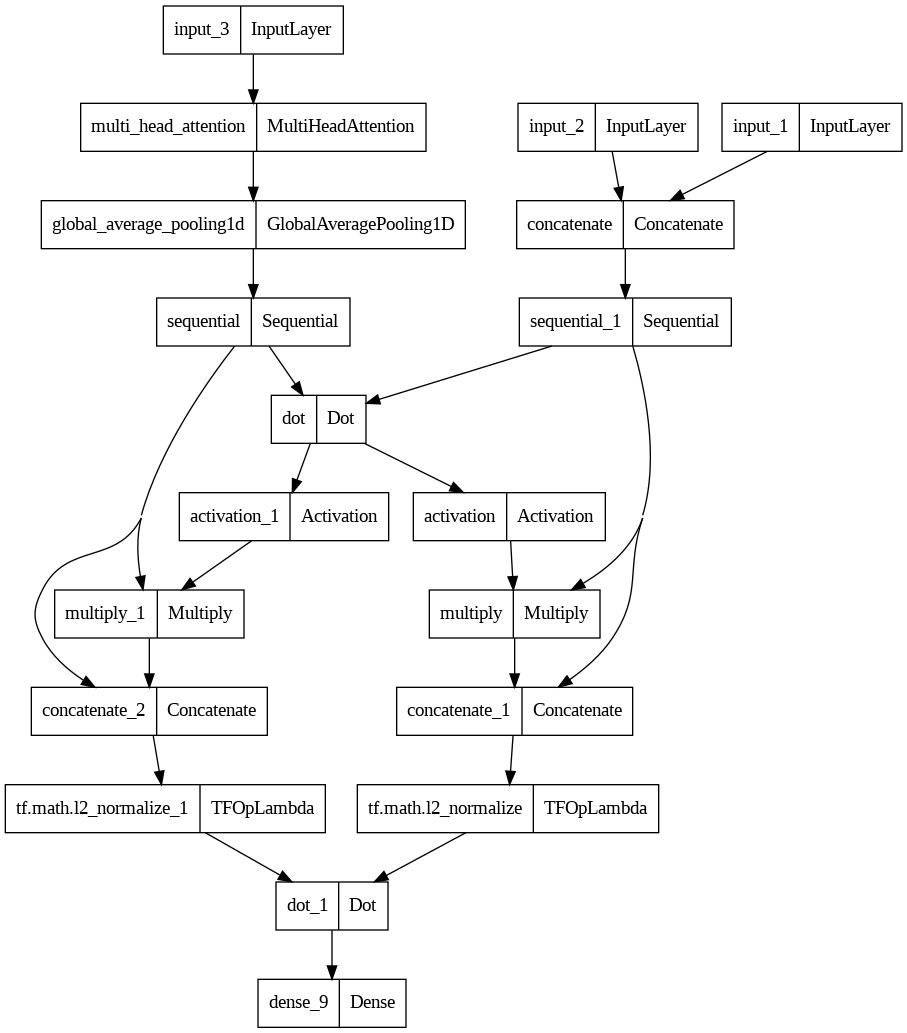

In [59]:
tf.keras.utils.plot_model(model_rc, "/content/my_model.png")

In [64]:
def contrastive_loss(y_true, y_pred, margin=1):
    """
    Contrastive loss function.
    - y_true: True labels, 1 for positive pairs, 0 for negative pairs.
    - y_pred: Predicted labels.
    - margin: Contrastive margin.
    """
    # 计算正样本的损失（用户购买车型）
    positive_loss = y_true * tf.square(y_pred)

    # 计算负样本的损失（用户未购买车型）
    negative_loss = (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0))

    # 计算总损失
    loss = tf.reduce_mean(positive_loss + negative_loss)
    return loss


In [80]:
# def contrastive_loss(y_true, y_pred, margin=1):
#     """
#     Contrastive loss function for binary classification.
#     - y_true: True labels, 1 for positive pairs, 0 for negative pairs.
#     - y_pred: Predicted probabilities.
#     - margin: Margin for negative samples.
#     """
#     # 计算正样本的损失（用户购买车型）
#     positive_loss = y_true * tf.keras.backend.binary_crossentropy(y_true, y_pred)

#     # 计算负样本的损失（用户未购买车型），使用margin
#     negative_loss = (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0))

#     # 计算总损失
#     loss = tf.reduce_mean(positive_loss + negative_loss)
#     return loss


In [65]:
# tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.005)
model_rc.compile(optimizer=opt, loss=contrastive_loss)

# contrastive_loss

In [66]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=60, # number of epochs to wait
                                                  restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', # monitor the validation loss
    factor=0.5,         # reduce the learning rate to 10% of its current value
    patience=30,         # reduce the learning rate if the metric does not improve for 5 consecutive epochs
    min_lr=1e-7,        # set the minimum learning rate
    verbose=1           # print messages about learning rate reduction
)

In [67]:
# 创建ModelCheckpoint回调
checkpoint_filepath = '/content/best_model2.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_weights_only=False # 保存整个模型。如果只想保存权重，设置为True。
)

In [68]:
# tf.random.set_seed(1)
# model.fit([user_train, car_train], ys_train, epochs=12)
history = model_rc.fit([uc_train_emb_tensor, user_train_num_tensor, car_train_num_tensor], ys_train_tensor,
                    epochs=100,
                    validation_data=([uc_test_emb_tensor, user_test_num_tensor, car_test_num_tensor], ys_test_tensor),
                    callbacks = [model_checkpoint_callback, early_stopping, reduce_lr_callback])


Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 0.2514
Epoch 1: val_loss improved from inf to 0.24900, saving model to /content/best_model2.h5
125/125 [==============================] - 13s 70ms/step - loss: 0.2514 - val_loss: 0.2490 - lr: 0.0050
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 0.2479
Epoch 2: val_loss did not improve from 0.24900
125/125 [==============================] - 8s 64ms/step - loss: 0.2479 - val_loss: 0.2490 - lr: 0.0050
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 0.2477
Epoch 3: val_loss did not improve from 0.24900
125/125 [==============================] - 8s 63ms/step - loss: 0.2477 - val_loss: 0.2491 - lr: 0.0050
Epoch 4/100
125/125 [==============================] - ETA: 0s - loss: 0.2476
Epoch 4: val_loss did not improve from 0.24900
125/125 [==============================] - 8s 63ms/step - loss: 0.2476 - val_loss: 0.2492 - lr: 0.0050
Epoch 5/100
125/125 [=========================

KeyboardInterrupt: ignored

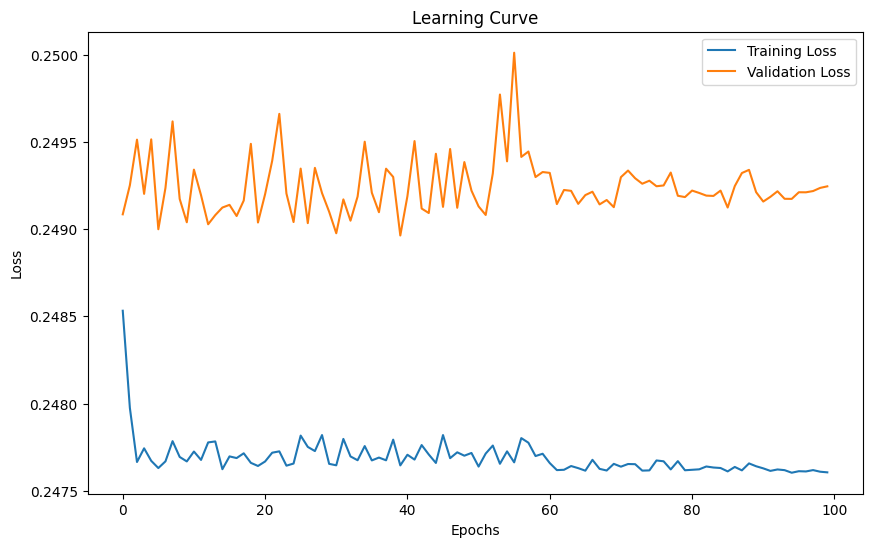

In [301]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# test

In [ ]:
# # preprocessing function for users comments
# def embeddings_for_comments(comments, max_length_comments, stride):
#     comments_emb = [None] * len(comments)  # 初始化一个足够大的列表来存储嵌入

#     # embeddings for user comments
#     for k, sent in enumerate(comments):
#       tokenized_inputs = tokenizer(text=text_clean(sent),
#                              add_special_tokens=True,
#                              return_overflowing_tokens=True,
#                              max_length=max_length_comments,
#                              stride=stride,
#                              return_tensors="tf",
#                              truncation=True)
#       # 分别处理每个分割后的部分
#       sent_embeddings = []
#       for i in range(len(tokenized_inputs["input_ids"])):
#         input_ids = tf.expand_dims(tokenized_inputs["input_ids"][i], 0)  # 添加batch维度
#         attention_mask = tf.expand_dims(tokenized_inputs["attention_mask"][i], 0)
#         # 在TensorFlow中，模型推断默认不计算梯度，所以不需要torch.no_grad()
#         output = model(input_ids, attention_mask=attention_mask)
#         sent_embeddings.append(output.last_hidden_state)

#       # # 对所有分割的嵌入进行平均池化以获得单个句子的嵌入
#       # sent_embeddings = tf.concat(sent_embeddings, axis=0)  # 将分割嵌入拼接起来
#       # sent_embedding = tf.reduce_mean(sent_embeddings, axis=0)  # 在所有分割上进行平均池化

#       comments_emb[k] = sent_embeddings

#     return comments_emb


In [ ]:
def embeddings_for_features(features, max_length_comments, stride):
    # 初始化嵌入的数组，形状与输入相同
    # features_emb = np.zeros((features.shape[0], features.shape[1], <嵌入维度>), dtype=np.float32)

    # 假设有一个函数来确定嵌入维度，或者您可以硬编码它
    embedding_dim = 768
    features_emb = np.zeros((features.shape[0], features.shape[1], embedding_dim))

    # 确保模型在GPU上
    # model.to('cuda')

    # 对每个用户的每个特征进行嵌入
    # 外层循环：遍历每个用户
    for user_index in tqdm(range(len(features)), desc="Processing users"):
        # 内层循环：遍历每个用户的特征
        for feature_index in range(features.shape[1]):
            feature_text = str(features[user_index][feature_index])
            feature_text = feature_text if feature_text is not None else ""
            # 清洗文本
            clean_text = text_clean(feature_text)
            # 分词和编码文本
            tokenized_inputs = tokenizer(
                text=clean_text,
                add_special_tokens=True,
                return_overflowing_tokens=True,
                max_length=max_length_comments,
                stride=stride,
                return_tensors="tf",
                truncation=True
            )

            # 分别处理每个分割后的部分
            feature_embeddings = []
            for i in range(len(tokenized_inputs["input_ids"])):
                input_ids = tf.expand_dims(tokenized_inputs["input_ids"][i], 0)
                attention_mask = tf.expand_dims(tokenized_inputs["attention_mask"][i], 0)
                # output = model(input_ids, attention_mask=attention_mask)
                with tf.device('/GPU:0'):  # 指定在第一个GPU上执行
                    output = model(input_ids, attention_mask=attention_mask)
                feature_embeddings.append(output.last_hidden_state)

            # 选择嵌入的第一个token ([CLS] token)，并移除额外的维度
            feature_embedding = tf.reduce_mean(tf.stack(feature_embeddings), axis=1)
            feature_embedding = feature_embedding[:, 0, :]  # 选择 [CLS] token 的嵌入

            # 存储每个特征的池化嵌入
            features_emb[user_index, feature_index, :] = feature_embedding.numpy()

    return features_emb

In [ ]:
# preprocessing function for other text features
def embeddings_for_oth_fea(feature_texts, max_length):
    # 存储所有句子的嵌入
    embeddings = []
    # 对每个句子进行编码
    for sent in feature_texts:
      tokenized_inputs = tokenizer(
          text=text_clean(sent),
          add_special_tokens=True,
          max_length=max_length,
          return_tensors="tf",
          truncation=True
          )
      # 由于我们不处理超长文本，不再需要检查是否有多个部分
      # 直接获取编码后的input_ids和attention_mask
      input_ids = tokenized_inputs["input_ids"]
      attention_mask = tokenized_inputs["attention_mask"]

      # 使用模型进行推断，并将得到的嵌入添加到embeddings列表
      output = model(input_ids, attention_mask=attention_mask)
      embeddings.append(output.last_hidden_state)

    return embeddings

In [ ]:
embed_comments = embeddings_for_features(user_vecs_nnum, max_length_comments, stride)

Processing users:  13%|█▎        | 1452/10879 [18:26<2:00:58,  1.30it/s]

In [ ]:
tokenized_inputs["input_ids"]

tensor([[ 101,  101,  523, 3297, 4007, 2692, 4638,  671, 4157,  524,  102, 6821,
         6775, 6756, 1798, 2769, 6230, 2533, 2769, 3297, 6371, 1377, 2124, 4638,
         1765, 3175, 2218, 3221, 2124, 4638, 4958, 7313, 8024, 4696, 4638, 3221,
         6392, 6369, 4638, 4294, 1166, 1168,  855, 8024, 2215, 1071, 3221, 2124,
         4638,  712, 7730,  855, 5390, 4638, 6392, 6369, 8024, 4696, 4638, 3221,
         6375, 2769, 2697, 6230, 4294, 1166, 4638, 2160, 3351, 8024, 1728,  711,
         2769, 3315, 6716, 3683, 6772, 5523, 8024, 1348, 2682,  743,  671, 6775,
         6821, 4905, 4958, 7313, 3683, 6772, 1920, 4638, 6756, 1798, 5543, 1916,
         4007, 6639,  671, 2157,  782, 1139, 6121, 4638, 7444, 3724, 8024, 2792,
          809,  738, 3221, 2190, 3683,  749, 2523, 1914, 4638, 6756, 1798, 8024,
          852, 3221, 3300, 4638, 6756,  833,  712, 7730,  855, 5390, 2160, 3351,
         8024, 1400, 2961,  855, 5390,  679, 1922, 4415, 2682, 8024, 3300, 4638,
         3221, 1400, 2961,  

In [ ]:
len(tokenized_inputs)

5

In [ ]:
# 分割文本为适应模型最大长度的多个部分
max_length = 512  # 模型的最大长度限制
stride = 256  # 可以重叠的token数量

In [ ]:
# 使用tokenizer的`encode_plus`和`stride`进行智能分割
tokenized_inputs = tokenizer(text,
                             add_special_tokens=True,
                             return_overflowing_tokens=True,
                             max_length=max_length,
                             stride=stride,
                             return_tensors="pt",
                             truncation=True)


In [ ]:
# 分别处理每个分割后的部分
embeddings = []
for i in range(len(tokenized_inputs["input_ids"])):
    input_ids = tokenized_inputs["input_ids"][i].unsqueeze(0)  # 添加batch维度
    attention_mask = tokenized_inputs["attention_mask"][i].unsqueeze(0)
    with torch.no_grad():
        output = model(input_ids, attention_mask=attention_mask)
        embeddings.append(output.last_hidden_state)

In [ ]:
# 假设 'embeddings' 是一个包含多个嵌入张量的列表
for i, embedding in enumerate(embeddings):
    print(f"Embedding {i} shape: {embedding.shape}")


Embedding 0 shape: torch.Size([1, 512, 768])


In [ ]:
# 将文本分割为最大长度为BERT模型的最大长度的段落
max_length = 512  # BERT的最大序列长度
# 分词，确保在句子或段落边界分割
words = tokenizer.tokenize(long_text)
segments = [' '.join(words[i:i+max_length]) for i in range(0, len(words), max_length)]

# 对每个段落进行编码
input_ids = [tokenizer.encode(segment, add_special_tokens=True) for segment in segments]

# 将编码后的数据转化为tensor
input_tensors = [torch.tensor([segment_ids]) for segment_ids in input_ids]

# 使用BERT模型获取每个段落的表示
with torch.no_grad():
    segment_embeddings = [model(input_tensor)[0] for input_tensor in input_tensors]

# 假设我们使用第一个token（[CLS]标记）的输出来代表这个段落
# 你也可以使用池化操作来获取整个段落的表示
document_embeddings = [segment_embedding[:, 0, :] for segment_embedding in segment_embeddings]

# 如果需要，你可以进一步将这些段落级表示汇总为文档级表示
# 例如，通过取平均值
document_embedding = torch.mean(torch.stack(document_embeddings), dim=0)

# 现在你可以使用document_embedding作为你的文档表示，进一步进行推荐系统的训练或推理

# roformer

In [266]:
from transformers import RoFormerTokenizer, RoFormerForSequenceClassification
import torch

In [267]:
# 指定模型版本
model_name = 'junnyu/roformer_v2_chinese_char_large'

# 加载分词器和模型
tokenizer = RoFormerTokenizer.from_pretrained(model_name)
model = RoFormerForSequenceClassification.from_pretrained(model_name)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'RoFormerTokenizer'.
Some weights of RoFormerForSequenceClassification were not initialized from the model checkpoint at junnyu/roformer_v2_chinese_char_large and are newly initialized: ['roformer.encoder.layer.4.attention.output.LayerNorm.bias', 'roformer.encoder.layer.6.intermediate.dense.bias', 'roformer.encoder.layer.5.output.LayerNorm.weight', 'roformer.encoder.layer.4.attention.self.value.bias', 'roformer.encoder.layer.14.attention.output.LayerNorm.bias', 'roformer.encoder.layer.12.attention.output.dense.bias', 'roformer.encoder.layer.0.attention.self.query.bias', 'roformer.encoder.layer.20.attention.output.LayerNorm.weight', 'roformer.encoder.layer.3.intermediate.dense.bias', 'roformer.encoder.layer.12.attention.s

In [ ]:
# 对文本进行分词处理
inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)

In [ ]:
# 预测
with torch.no_grad():
    logits = model(**inputs).logits

# 获得预测结果
predicted_class_id = logits.argmax().item()
print("Predicted class:", predicted_class_id)

Predicted class: 0


In [ ]:
from transformers import RoFormerTokenizer, RoFormerModel
import torch

# 初始化分词器和模型
tokenizer = RoFormerTokenizer.from_pretrained('junnyu/roformer_v2_chinese_char_large')
model = RoFormerModel.from_pretrained('junnyu/roformer_v2_chinese_char_large')

# 示例文本
text = "&#8203;``【oaicite:0】``&#8203;感觉不错，7座比5座好..."

# 分词
inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)

# 生成嵌入
with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state

# 这里的`embeddings`是最后一层的隐藏状态，您可以使用它们作为文本的嵌入表示。


In [260]:
pip install roformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 11.2 MB/s eta 0:00:00


In [ ]:
# from transformers import RoFormerTokenizer, RoFormerForSequenceClassification

In [261]:
from roformer import TFRoFormerForMaskedLM

In [264]:
tokenizer = BertTokenizer.from_pretrained("junnyu/roformer_v2_chinese_char_large")
tf_model = TFRoFormerForMaskedLM.from_pretrained(
    "junnyu/roformer_v2_chinese_char_large", from_pt=True
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRoFormerForMaskedLM: ['cls.predictions.decoder.weight']
- This IS expected if you are initializing TFRoFormerForMaskedLM from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRoFormerForMaskedLM from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRoFormerForMaskedLM were not initialized from the PyTorch model and are newly initialized: ['roformer.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [265]:
# 加载分词器和模型
tokenizer = RoFormerTokenizer.from_pretrained('junnyu/roformer_v2_chinese_char_large')
model = RoFormerForSequenceClassification.from_pretrained('junnyu/roformer_v2_chinese_char_large')

NameError: ignored

In [ ]:

# 对文本进行分词处理
inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True)

# 预测
with torch.no_grad():
    logits = model(**inputs).logits

# 获得预测结果
predicted_class_id = logits.argmax().item()
print("Predicted class:", predicted_class_id)


RuntimeError: ignored

In [ ]:
pip install roformer

In [ ]:
tf_inputs = tokenizer(text, return_tensors="tf")

In [ ]:
tf_outputs = tf_model(**tf_inputs, training=False).logits[0]
tf_outputs_sentence = "tf: "

In [ ]:


# pt_model = RoFormerForMaskedLM.from_pretrained("junnyu/roformer_v2_chinese_char_large")
tf_model = TFRoFormerForMaskedLM.from_pretrained(
    "junnyu/roformer_v2_chinese_char_large", from_pt=True
)
# pt_inputs = tokenizer(text, return_tensors="pt")
tf_inputs = tokenizer(text, return_tensors="tf")
# # pytorch
# with torch.no_grad():
#     pt_outputs = pt_model(**pt_inputs).logits[0]
# pt_outputs_sentence = "pytorch: "
# for i, id in enumerate(tokenizer.encode(text)):
#     if id == tokenizer.mask_token_id:
#         tokens = tokenizer.convert_ids_to_tokens(pt_outputs[i].topk(k=5)[1])
#         pt_outputs_sentence += "[" + "||".join(tokens) + "]"
#     else:
#         pt_outputs_sentence += "".join(
#             tokenizer.convert_ids_to_tokens([id], skip_special_tokens=True)
#         )
# print(pt_outputs_sentence)
# tf
tf_outputs = tf_model(**tf_inputs, training=False).logits[0]
tf_outputs_sentence = "tf: "
for i, id in enumerate(tokenizer.encode(text)):
    if id == tokenizer.mask_token_id:
        tokens = tokenizer.convert_ids_to_tokens(tf.math.top_k(tf_outputs[i], k=5)[1])
        tf_outputs_sentence += "[" + "||".join(tokens) + "]"
    else:
        tf_outputs_sentence += "".join(
            tokenizer.convert_ids_to_tokens([id], skip_special_tokens=True)
        )
print(tf_outputs_sentence)
# small
# pytorch: 今天[的||，||是||很||也]很好，我[要||会||是||想||在]去公园玩。
# tf: 今天[的||，||是||很||也]很好，我[要||会||是||想||在]去公园玩。
# base
# pytorch: 今天[我||天||晴||园||玩]很好，我[想||要||会||就||带]去公园玩。
# tf: 今天[我||天||晴||园||玩]很好，我[想||要||会||就||带]去公园玩。
# large
# pytorch: 今天[天||气||我||空||阳]很好，我[又||想||会||就||爱]去公园玩。
# tf: 今天[天||气||我||空||阳]很好，我[又||想||会||就||爱]去公园玩。
